# Include Weather Data

Include all possible dimensions and train a treebased classifier

In [1]:
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import metrics
from sklearn import utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error,mean_squared_error

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

## Load Data

In [6]:
df = pd.read_csv('/Users/leima/data_store/rideindego_all.csv')
df['date'] = pd.to_datetime(df.date)
df_weather = pd.read_csv('data/philadelphia_weather.csv')[['date', 'hour', 'avg_temp', 'avg_humid', 'avg_wind_speed', 'avg_pressure']]
df_weather['date'] = pd.to_datetime(df_weather.date)
df = pd.merge(df, df_weather, how='left', left_on=['date', 'hour'], right_on=['date', 'hour'])

/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,3,4,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
df.head()

,bike_id,bike_type,duration,end_lat,end_lon,end_station_id,end_time,passholder_type,plan_duration,start_lat,...,trip_id,trip_route_category,date,hour,weekday,month,avg_temp,avg_humid,avg_wind_speed,avg_pressure
0,3640,standard,4.0,39.9384,-75.173271,3064,7/1/2016 0:11,Indego30,30,39.946331,...,25183529,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
1,3349,standard,8.0,39.94138,-75.145638,3026,7/1/2016 0:18,Indego30,30,39.95295,...,25183528,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
2,5279,standard,17.0,39.933151,-75.162483,3034,7/1/2016 0:28,Indego30,30,39.93082,...,25183527,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
3,5198,standard,25.0,39.94138,-75.145638,3026,7/1/2016 0:38,Walk-up,0,39.94138,...,25183526,Round Trip,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6
4,3382,standard,45.0,39.947109,-75.166183,3010,7/1/2016 0:58,Walk-up,0,39.954239,...,25183525,One Way,2016-07-01,0,4,7,78.1,58.0,9.2,1016.6


In [8]:
df = df[df.bike_type == 'standard']
coi = [
    'plan_duration', 
    'trip_route_category', 'hour', 'weekday', 'month', 'avg_temp', 'avg_wind_speed', 'avg_pressure'
]
#avg_humid is correlated to the hour of the day
cot = ['duration']
df = df[coi+cot]
df.dropna(inplace=True)

In [9]:
df.head()

,plan_duration,trip_route_category,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
0,30,One Way,0,4,7,78.1,9.2,1016.6,4.0
1,30,One Way,0,4,7,78.1,9.2,1016.6,8.0
2,30,One Way,0,4,7,78.1,9.2,1016.6,17.0
3,0,Round Trip,0,4,7,78.1,9.2,1016.6,25.0
4,0,One Way,0,4,7,78.1,9.2,1016.6,45.0


In [10]:
df.describe()

,plan_duration,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
count,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06,2.612692e+06
mean,4.475853e+01,1.388563e+01,2.853611e+00,7.048581e+00,6.489027e+01,9.139138e+00,1.017669e+03,2.267813e+01
std,8.025856e+01,4.992925e+00,1.929616e+00,2.940383e+00,1.667288e+01,5.093160e+00,6.865514e+00,6.828042e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,6.100000e+00,0.000000e+00,9.837000e+02,1.000000e+00
25%,3.000000e+01,1.000000e+01,1.000000e+00,5.000000e+00,5.310000e+01,5.800000e+00,1.013400e+03,8.000000e+00
50%,3.000000e+01,1.500000e+01,3.000000e+00,7.000000e+00,6.800000e+01,8.470000e+00,1.017600e+03,1.200000e+01
75%,3.000000e+01,1.800000e+01,4.000000e+00,9.000000e+00,7.810000e+01,1.265000e+01,1.022000e+03,1.900000e+01
max,3.650000e+02,2.300000e+01,6.000000e+00,1.200000e+01,9.700000e+01,4.683000e+01,1.044400e+03,1.440000e+03


Check correlations

/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


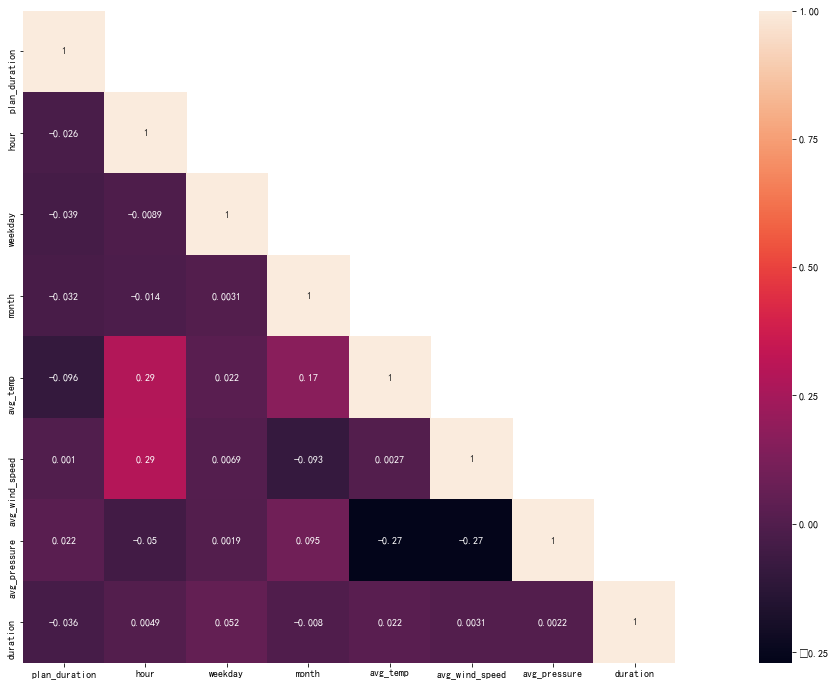

In [11]:
cor_mat = df.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [12]:
for i in df.columns:
    print(
        i, ': ',
        df[i].isnull().any()
    )

plan_duration :  False
trip_route_category :  False
hour :  False
weekday :  False
month :  False
avg_temp :  False
avg_wind_speed :  False
avg_pressure :  False
duration :  False


In [13]:
scaler = StandardScaler()

In [14]:
X = df[coi]
#X = pd.get_dummies(X)
y = df[cot]
y = scaler.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3, random_state=42
    #,stratify=Y
)

In [15]:
class MultiColumnLabelEncoder:
    def __init__(self, encoders = None, columns = None):
        self.columns = columns # array of column names to encode
        if encoders:
            self.encoders = encoders
        else:
            self.encoders = {}

    def fit(self,X,y=None):
        self.check_encoders = []
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[col] = self.encoders.get(col).transform(output[col])
                else:
                    output[col] = _le.fit_transform(output[col])
                    print(f'1. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        else:
            for colname,col in output.iteritems():
                _le = LabelEncoder()
                if self.encoders.get(col):
                    output[colname] = self.encoders.get(col).transform(col)
                else:
                    output[colname] = _le.fit_transform(col)
                    print(f'2. preparing encoder for {col}')
                    self.encoders[col] = _le
                    self.check_encoders.append({col: _le})
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [16]:
encoders_obj = MultiColumnLabelEncoder(columns=coi)
df_transformed = encoders_obj.fit_transform(df)
dt_encoders = encoders_obj.encoders

1. preparing encoder for plan_duration
1. preparing encoder for trip_route_category
1. preparing encoder for hour
1. preparing encoder for weekday
1. preparing encoder for month
1. preparing encoder for avg_temp
1. preparing encoder for avg_wind_speed
1. preparing encoder for avg_pressure


In [17]:
coi

['plan_duration',
 'trip_route_category',
 'hour',
 'weekday',
 'month',
 'avg_temp',
 'avg_wind_speed',
 'avg_pressure']

In [18]:
df_transformed.head()

,plan_duration,trip_route_category,hour,weekday,month,avg_temp,avg_wind_speed,avg_pressure,duration
0,3,0,0,4,6,1054,195,249,4.0
1,3,0,0,4,6,1054,195,249,8.0
2,3,0,0,4,6,1054,195,249,17.0
3,0,1,0,4,6,1054,195,249,25.0
4,0,0,0,4,6,1054,195,249,45.0


In [19]:
X_trans = df_transformed[coi]
y_trans = df_transformed[cot]

X_trans_train, X_trans_test, y_trans_train, y_trans_test = train_test_split(
    X_trans, y_trans,
    test_size=0.3, random_state=42
    #,stratify=Y
)

## NN

In [21]:
import tensorflow as tf

In [22]:
batch_size = 128
num_epochs = 10
shuffle=True

In [27]:
# input functions
input_fn_train = tf.estimator.inputs.pandas_input_fn(
  X_trans_train, y=y_trans_train,
  batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, target_column=cot[0]
)

input_fn_test = tf.estimator.inputs.pandas_input_fn(
  X_trans_test, y=y_trans_test,
  batch_size=batch_size, num_epochs=num_epochs, shuffle=shuffle, target_column=cot[0]
)


In [29]:
# model training and evaluation
model = tf.estimator.LinearClassifier(model_dir='/tmp/sfc_model', feature_columns=coi)
model.train(input_fn=input_fn_train)
results = model.evaluate(input_fn=input_fn_test)
for key in sorted(results):
  print('%s: %s' % (key, results[key]))

W0717 01:02:23.489599 140735649518464 deprecation.py:323] From /Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0717 01:02:23.520218 140735649518464 deprecation.py:323] From /Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/tensorflow_estimator/python/estimator/inputs/queues/feeding_queue_runner.py:62: QueueRunner.__init__ (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
W0717 01:02:23.523923 140735649518464 deprecation.py:323] From /Users/leima/anaconda/envs/saloodo/lib/python3.7/site-packages/tensorflow

ValueError: Items of feature_columns must be a _FeatureColumn. Given (type <class 'str'>): plan_duration.